In [1]:
import pandas as pd
import plotly.graph_objects as go

from plotnine import *
from plotnine import options

from pathlib import Path

In [2]:
OUTPUT_DIR = Path('../output/results')

## Load df

In [3]:
dfs = pd.DataFrame()

# Read all csv files in OUTPUT_DIR
for csv_path in OUTPUT_DIR.rglob('**/*.csv'):
    try:
        print(csv_path)
        df = pd.read_csv(csv_path)
        df.drop(['directory', 'START_TIME', 'END_TIME'], axis=1, inplace=True)
        df.fillna(0, inplace=True)
        dfs = pd.concat([dfs, df])
    except:
        pass

../output/results/cpu.csv
../output/results/gpu.csv
../output/results/gpu-1024.csv


In [4]:
#sort the results by the column 'threads' and the PHASE
dfs.sort_values(by=['threads', 'PHASE'], inplace=True)

#print the phases unique
print(dfs['PHASE'].unique())

['P1 - Rn_G' 'P2 - FINAL PRODUCTS' 'P2 - PIXEL SELECTION'
 'P2 - RAH - PARALLEL - CORE' 'P2 - RAH CYCLE' 'TOTAL']


In [5]:
# drop rows that not contains P1 or P2
dfs = dfs[dfs['PHASE'].str.contains('P1|P2') & dfs['PHASE'].notna()]
dfs['TIMESTAMP'] = dfs['TIMESTAMP'] * 1e-6
print(dfs['PHASE'].unique())

['P1 - Rn_G' 'P2 - FINAL PRODUCTS' 'P2 - PIXEL SELECTION'
 'P2 - RAH - PARALLEL - CORE' 'P2 - RAH CYCLE']


In [6]:
df.head(5)

,threads,device,PHASE,TIMESTAMP,CPU_MIN,CPU_MAX,CPU_MEAN,MEM_CPU_MIN,MEM_CPU_MAX,MEM_CPU_MEAN,GPU_MIN,GPU_MAX,GPU_MEAN,MEM_GPU_MIN,MEM_GPU_MAX,MEM_GPU_MEAN
0,1024,gpu,TOTAL,45167539610,92.0,101.0,99.760870,54370.0,63710.0,57963.043478,0.0,69.0,12.644444,0.0,3340.0,74.222222
1,1024,gpu,P2 - RAH CYCLE,10877790690,99.0,101.0,99.916667,55780.0,62560.0,58990.000000,11.0,23.0,12.181818,0.0,3340.0,303.636364
2,1024,gpu,P2 - RAH - PARALLEL - CORE,454810,99.0,99.0,99.000000,62300.0,62300.0,62300.000000,23.0,23.0,23.000000,3340.0,3340.0,3340.000000
3,1024,gpu,P2 - PIXEL SELECTION,7919606830,92.0,101.0,99.222222,55780.0,63710.0,61888.888889,5.0,31.0,12.666667,0.0,0.0,0.000000
4,1024,gpu,P1 - Rn_G,22009858684,98.0,100.0,99.869565,54370.0,60490.0,55151.739130,11.0,24.0,11.782609,0.0,0.0,0.000000


## Plots

In [7]:
gg_df = dfs[dfs['PHASE'].str.contains('PARALLEL')]

### Speedup

In [8]:
speedup = list()
for threads in gg_df['threads'].unique():
    for phase in gg_df['PHASE'].unique():
        for device in gg_df['device'].unique():
            threads_num = int(threads)
            seq_time = gg_df[(gg_df['threads'] == 1) &
                             (gg_df['PHASE'] == phase)]['TIMESTAMP'].median()

            current_time = gg_df[(gg_df['threads'] == threads) &
                                 (gg_df['PHASE'] == phase) &
                                 (gg_df['device'] == device)]['TIMESTAMP'].median()

            speedup.append({
                'PHASE': phase,
                'device': device,
                'threads': threads_num,
                'ideal_time': seq_time / threads_num,
                'real_time': current_time,
                'speedup': seq_time / current_time,
            })

speedup_df = pd.DataFrame(speedup)
speedup_df.sort_values(by=['device', 'PHASE', 'threads'], inplace=True)
speedup_df.head(5)

,PHASE,device,threads,ideal_time,real_time,speedup
0,P2 - RAH - PARALLEL - CORE,cpu,1,3850.530471,3850.530471,1.000000
2,P2 - RAH - PARALLEL - CORE,cpu,32,120.329077,NaN,NaN
4,P2 - RAH - PARALLEL - CORE,cpu,1024,3.760284,NaN,NaN
1,P2 - RAH - PARALLEL - CORE,gpu,1,3850.530471,NaN,NaN
3,P2 - RAH - PARALLEL - CORE,gpu,32,120.329077,1.741025,2211.645709


In [9]:
#drop row where speedup is NaN
speedup_df = speedup_df.dropna(subset=['speedup']).reset_index(drop=True)
speedup_df

,PHASE,device,threads,ideal_time,real_time,speedup
0,P2 - RAH - PARALLEL - CORE,cpu,1,3850.530471,3850.530471,1.000000
1,P2 - RAH - PARALLEL - CORE,gpu,32,120.329077,1.741025,2211.645709
2,P2 - RAH - PARALLEL - CORE,gpu,1024,3.760284,0.454810,8466.239685


/home/mestrado/.local/lib/python3.10/site-packages/plotnine/geoms/geom_path.py:113: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?
/home/mestrado/.local/lib/python3.10/site-packages/plotnine/geoms/geom_path.py:113: PlotnineWarning: geom_path: Each group consist of only one observation. Do you need to adjust the group aesthetic?


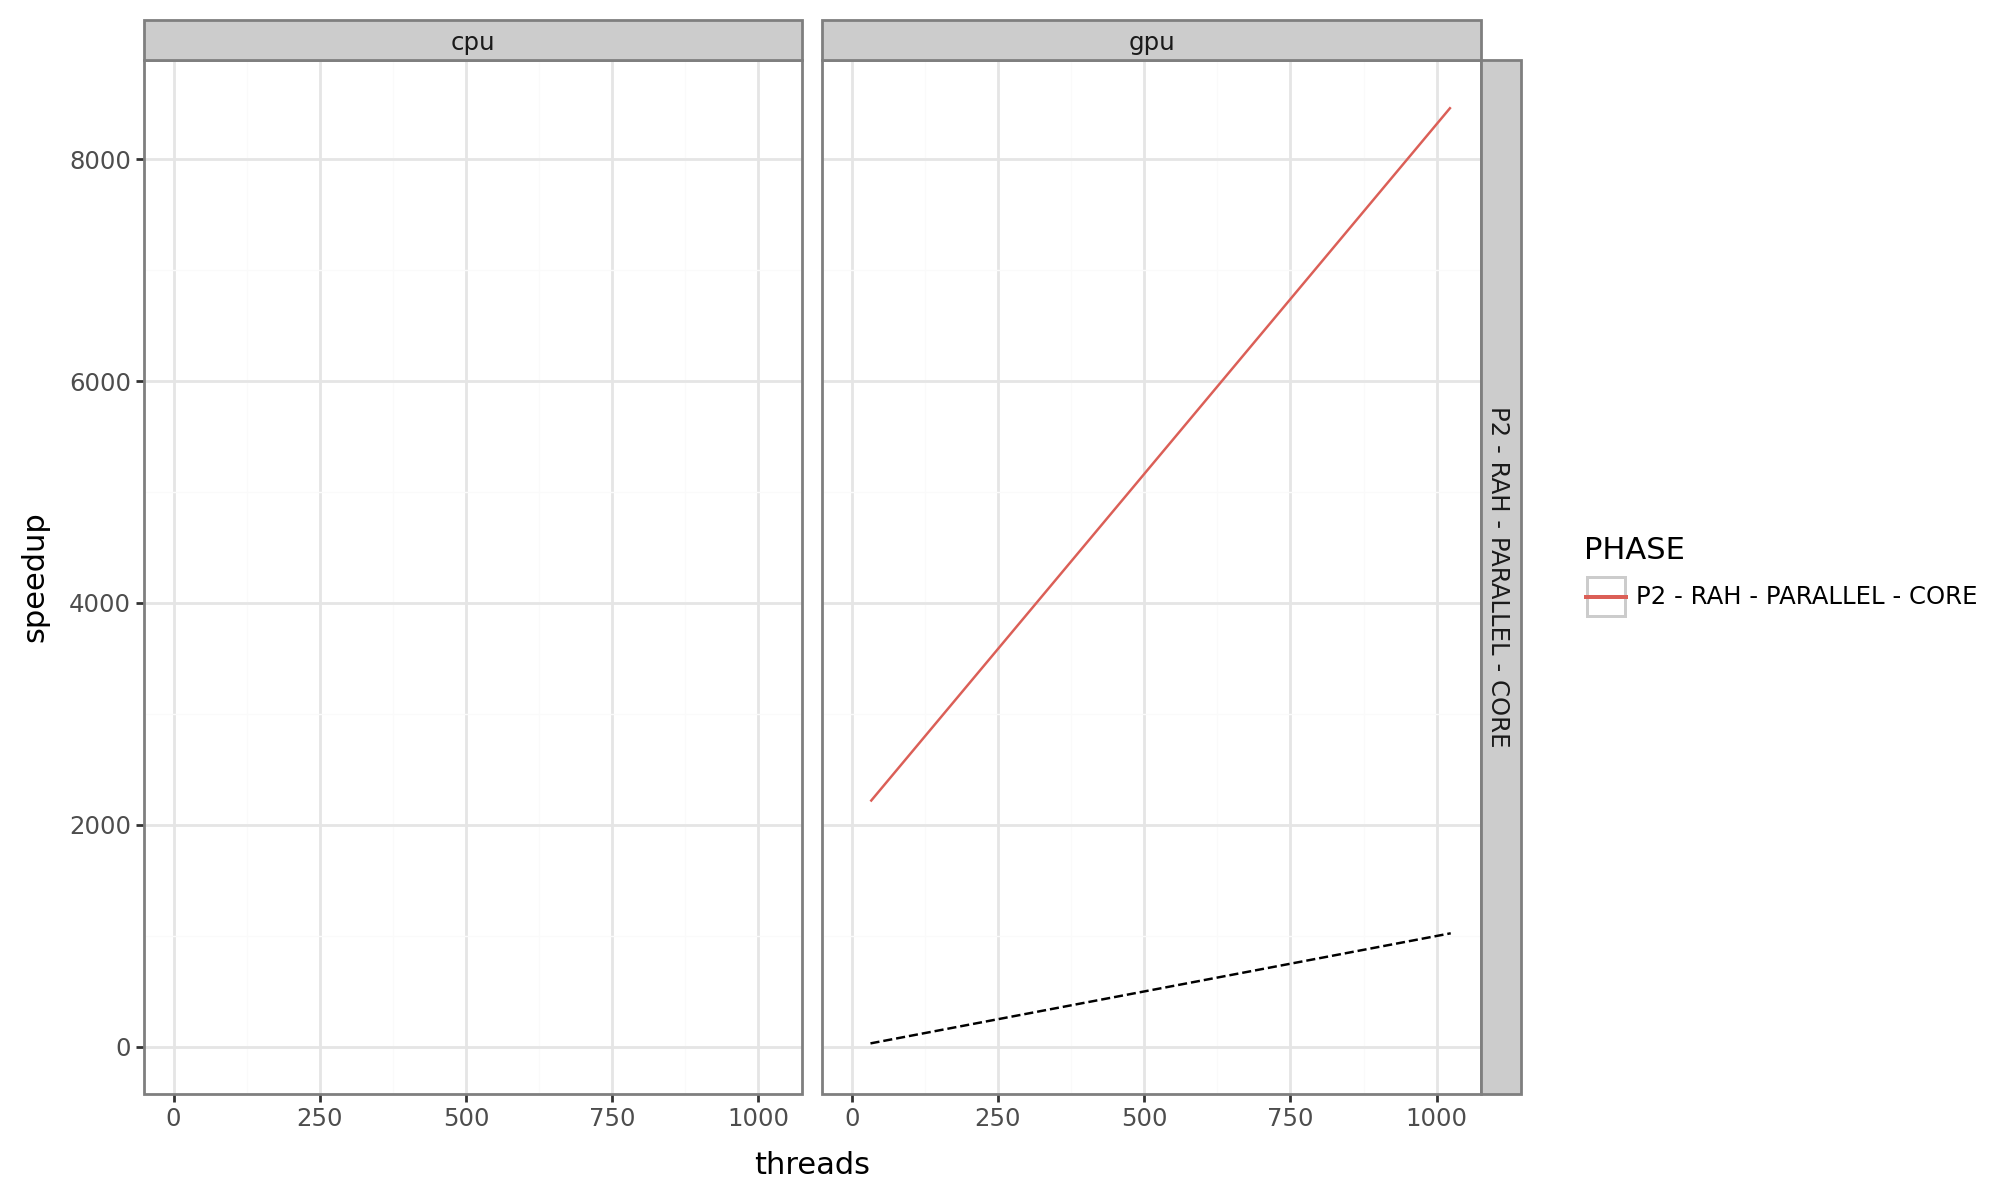

In [10]:
options.figure_size = (10, 6)

#each group must have more than one value
(ggplot(speedup_df, aes(x='threads', y='speedup', color='PHASE'))
 + geom_line()
 + geom_line(aes(x='threads', y='threads'), linetype='dashed', color='black')
 + facet_grid("PHASE ~ device")
 + labs(x="threads", y="speedup")
 + theme_bw())

### Timestamp

/home/mestrado/.local/lib/python3.10/site-packages/plotnine/guides/guides.py:207: PlotnineWarning: Cannot generate legend for the 'fill' aesthetic. Make sure you have mapped a variable to it


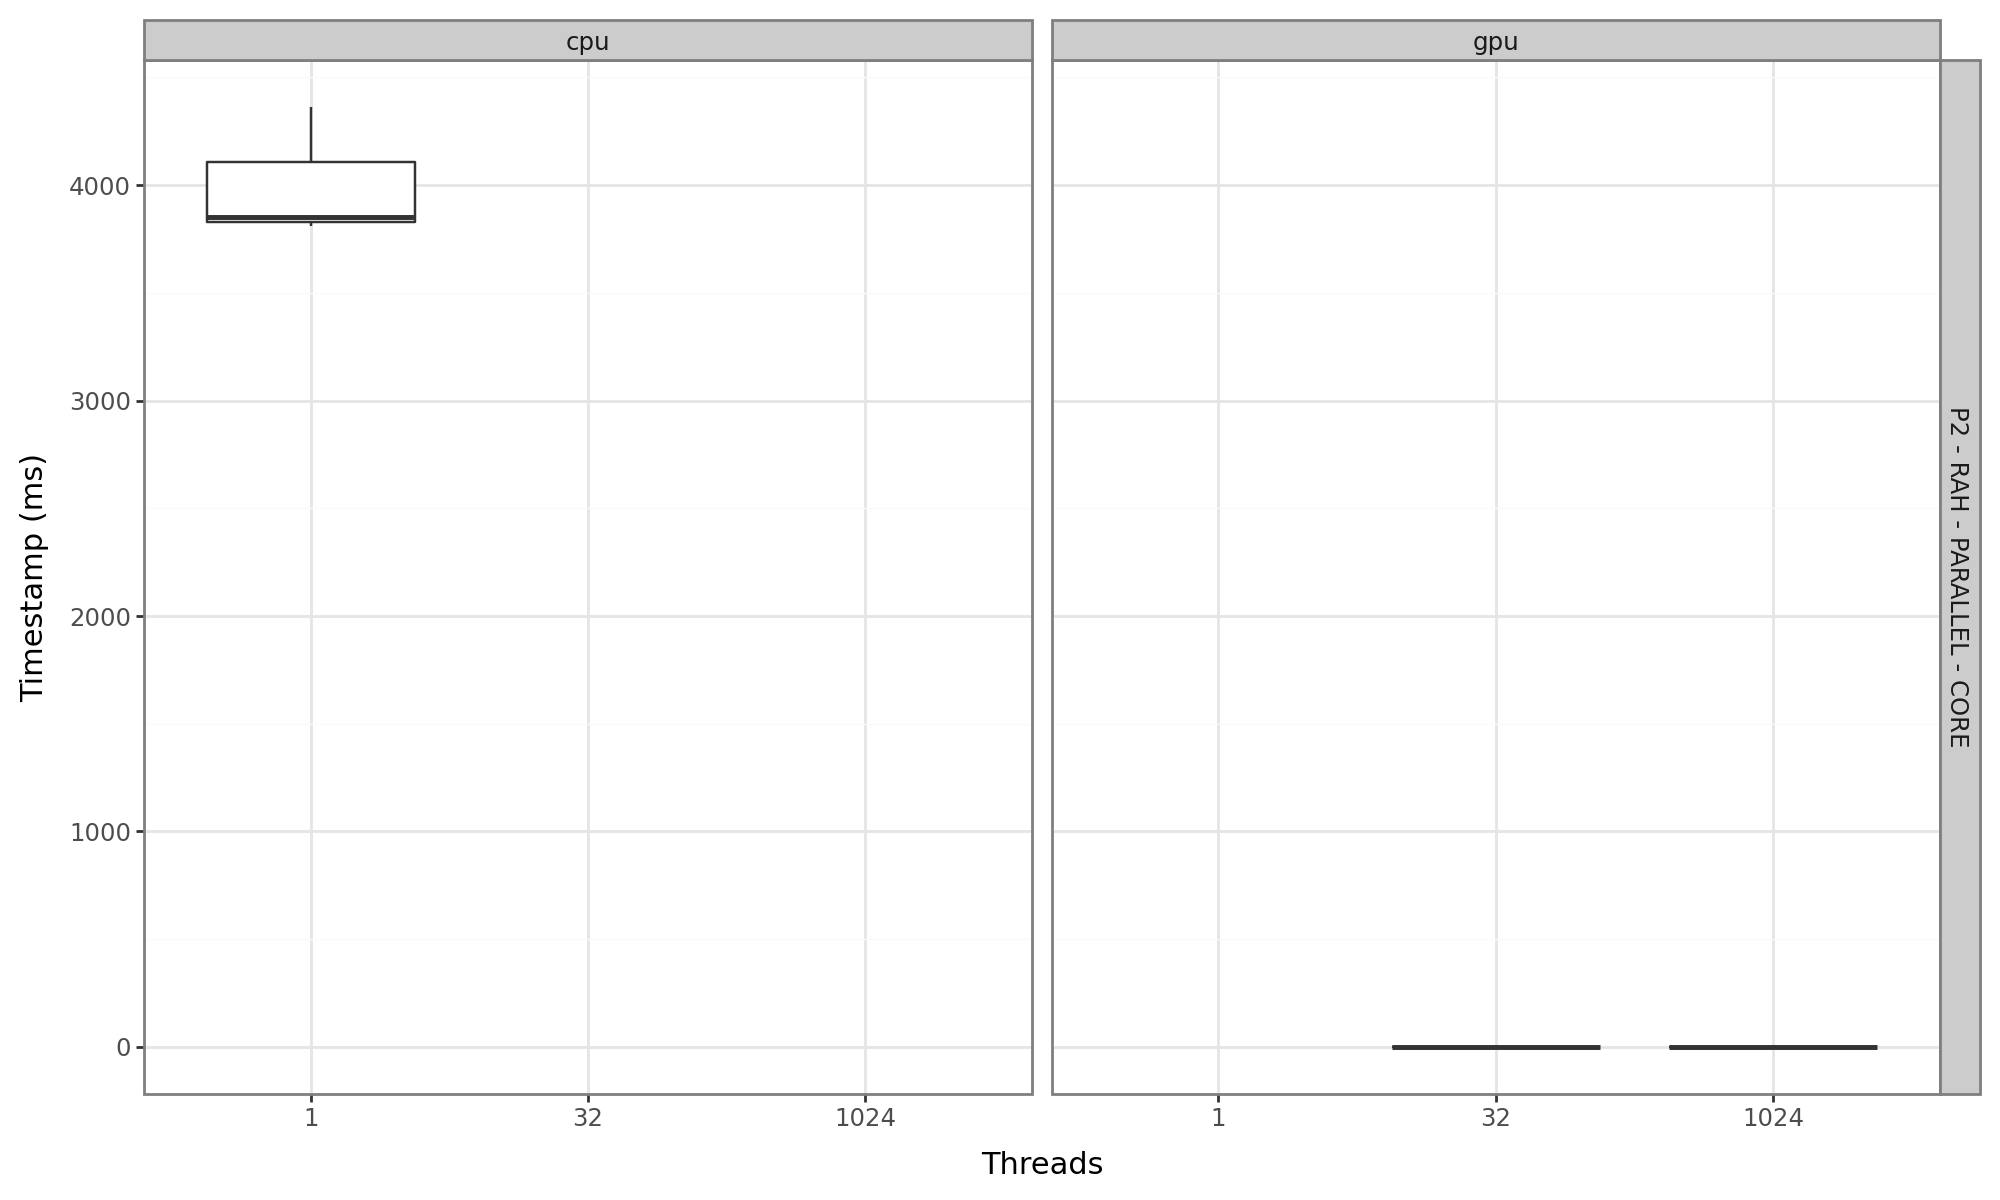

In [11]:
options.figure_size = (10, 6)

(ggplot(gg_df, aes(x='factor(threads)', y='TIMESTAMP'))
 + geom_boxplot()
 + facet_grid("PHASE ~ device")
 + scale_fill_hue()
 + labs(x="Threads", y="Timestamp (ms)")
 + theme_bw())

### CPU usage

/home/mestrado/.local/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_bar : Removed 3 rows containing missing values.


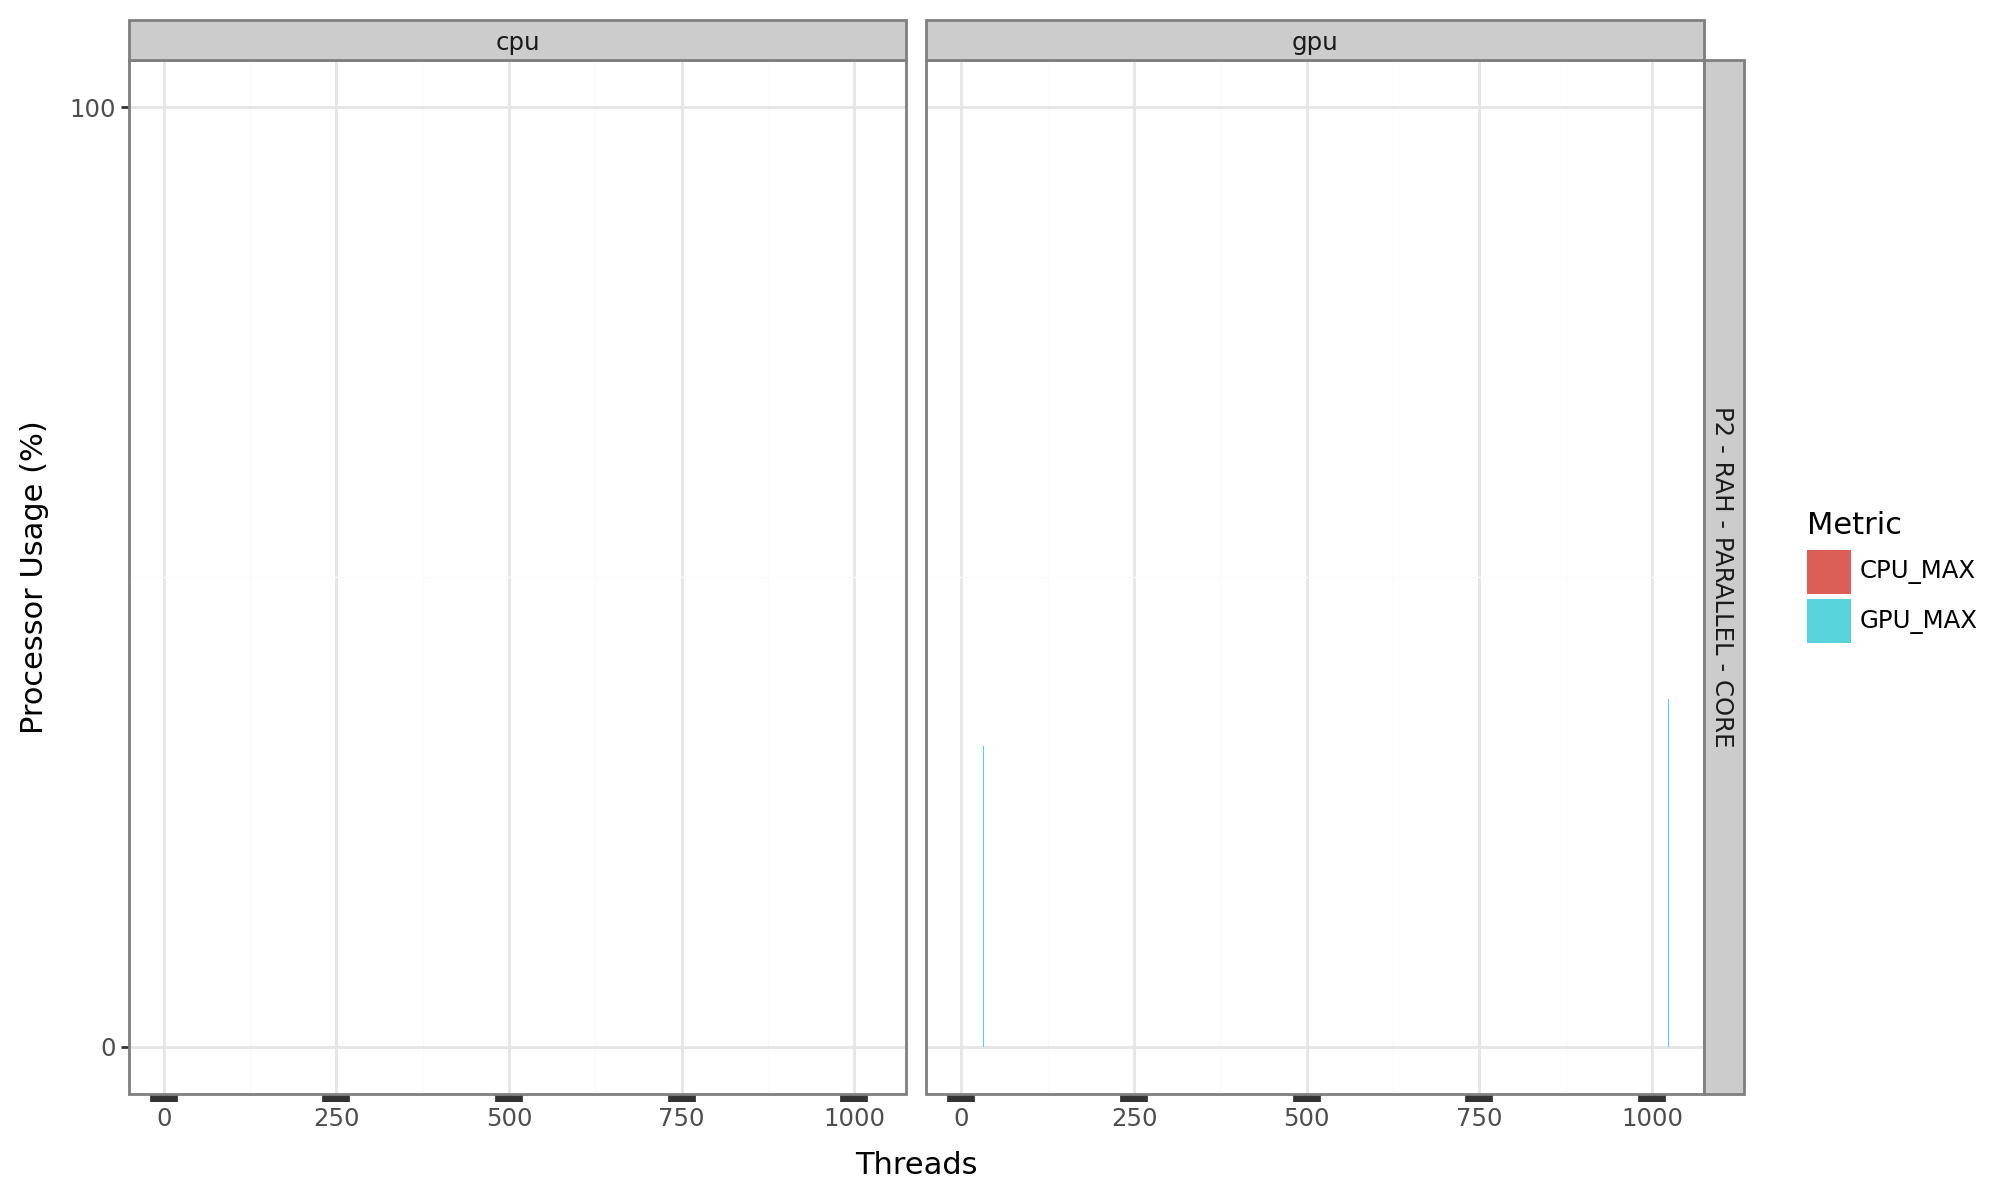

In [15]:
options.figure_size = (10, 6)

df_selected = gg_df[['threads', 'device', 'PHASE', 'CPU_MAX', 'GPU_MAX']]
df_melted = pd.melt(df_selected, id_vars=['threads', 'PHASE', 'device'], var_name='Metric', value_name='Value')

(ggplot(df_melted, aes(x='threads', y='Value', fill='Metric'))
 + geom_bar(stat='identity', position='dodge')
 + facet_grid("PHASE ~ device")
 + scale_y_continuous(breaks=range(0, int(df_melted['Value'].max()) + 100, 100))
 + labs(x="Threads", y="Processor Usage (%)")
 + scale_fill_hue()
 + theme_bw())

### Memory usage

/home/mestrado/.local/lib/python3.10/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_bar : Removed 3 rows containing missing values.


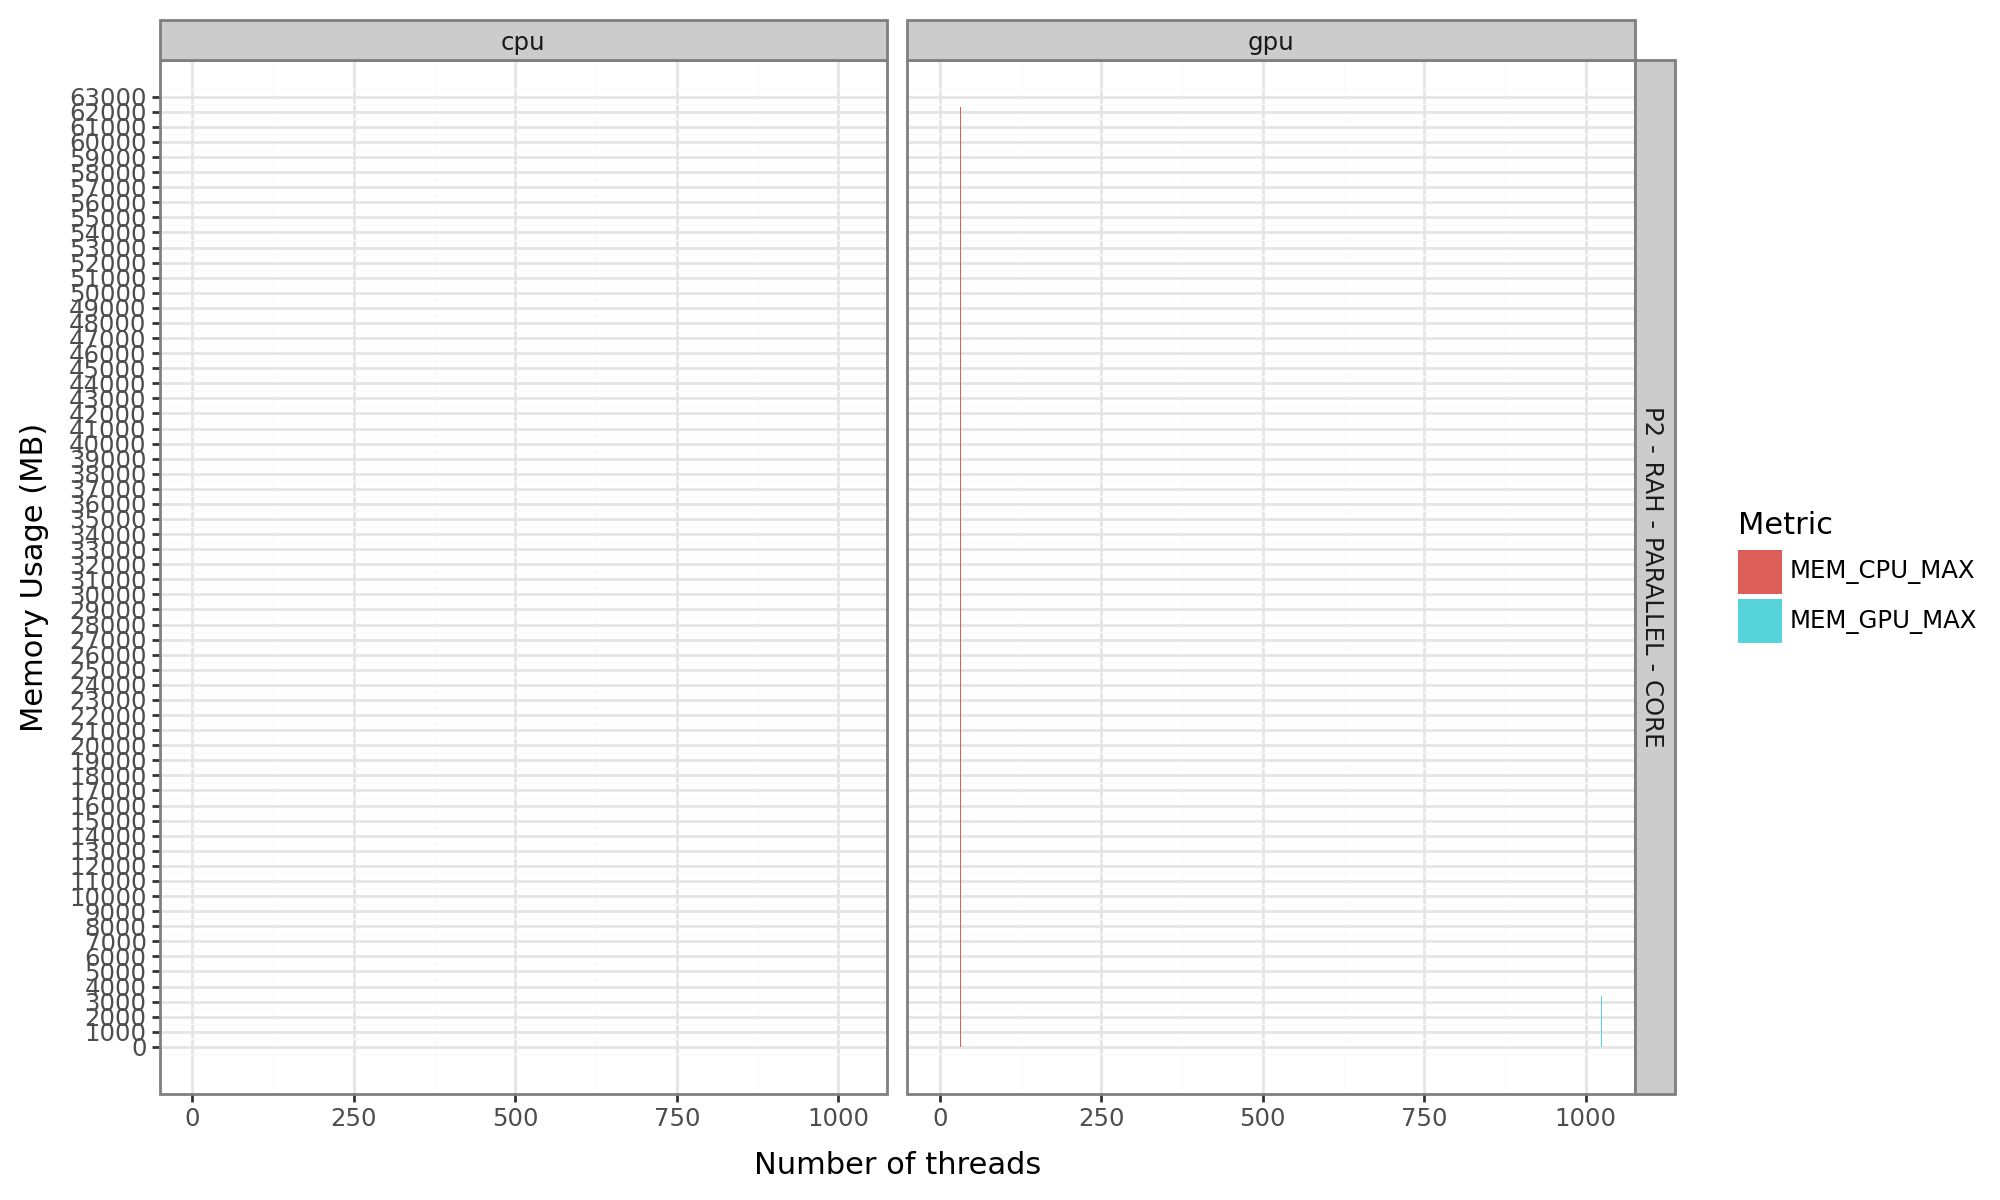

In [16]:
options.figure_size = (10, 6)

df_selected = gg_df[['threads', 'device', 'PHASE', 'MEM_GPU_MAX', 'MEM_CPU_MAX']]
df_melted = pd.melt(df_selected, id_vars=['threads', 'PHASE', 'device'], var_name='Metric', value_name='Value')

(ggplot(df_melted, aes(x='threads', y='Value', fill='Metric'))
 + geom_bar(stat='identity', position='dodge')
 + facet_grid("PHASE ~ device")
 + scale_y_continuous(breaks=range(0, int(df_melted['Value'].max()) + 1000, 1000))
 + labs(x='Number of threads', y='Memory Usage (MB)')
 + scale_fill_hue()
 + theme_bw())